In [79]:
from matplotlib.colors import ListedColormap
from sklearn import svm
from multiprocessing import Pool
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from itertools import product

In [7]:
N = 100
x = np.linspace(0,1,N)
y = (-1)**np.floor(10*x)

In [8]:
repetitions = 1
n_wires = 1

In [9]:
dev = qml.device('default.qubit', wires=n_wires)

In [10]:
# @qml.qnode(dev)
# def circ(xi, params):
#     qml.RY(params[0], wires=0)
#     qml.RZ(params[1], wires=0)

#     qml.Hadamard(wires=0)
#     qml.RZ(params[2]*xi, wires=0)

#     return qml.state()

In [11]:
@qml.qnode(dev)
def circ(xi, params):
    qml.Hadamard(wires=0)
    qml.RZ(params[0]*xi, wires=0)
    qml.Hadamard(wires=0)
    return qml.state()

In [12]:
params = 2*np.pi*np.random.rand(1)
print(params)

[2.76778521]


In [13]:
def kernel_matrix(X, params, kernel_circ, assume_normalized_kernel=False):
    states = np.array([kernel_circ(x, params) for x in X])
    
    N = len(X)
    matrix = [0] * N**2

    for i in range(N):
        for j in range(i, N):
            if assume_normalized_kernel and i == j:
                matrix[N * i + j] = 1.0
            else:
                matrix[N * i + j] = np.abs(np.dot(states[i],np.conj(states[j])))**2
                matrix[N * j + i] = matrix[N * i + j]

    return np.array(matrix).reshape((N, N))

def target_alignment_matrix(ker_matrix, Y, rescale_class_labels=True):
    
    K = ker_matrix

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product


def test_matrix(X_train, X_test, params, kernel_circ):
    states_train = np.array([kernel_circ(x, params) for x in X_train])
    states_test = np.array([kernel_circ(x, params) for x in X_test])
    
    M = len(X_train)
    N = len(X_test)
    matrix = [0] * N*M

    for i in range(N):
        for j in range(i, M):
            matrix[M * i + j] = np.abs(np.dot(states_train[j],np.conj(states_test[i])))**2
            matrix[N * j + i] = matrix[M * i + j]

    return np.array(matrix).reshape((N, M))

In [14]:
N = 100

x_train = np.random.rand(N)
y_train = (-1)**np.floor(10*x_train)

x_test = np.random.rand(N)
y_test = (-1)**np.floor(10*x_test)

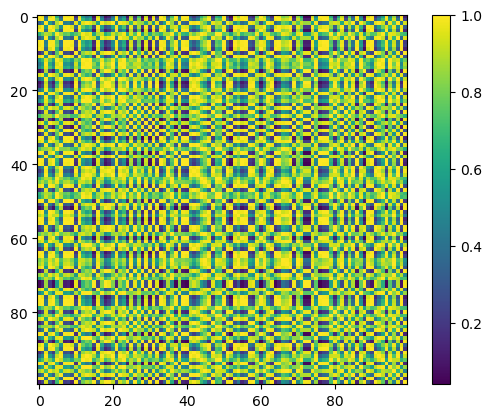

In [17]:
ker_matrix = kernel_matrix(x_train, params, circ)

plt.imshow(ker_matrix)
plt.colorbar()

In [18]:
target_alignment_matrix(ker_matrix, y)

0.00039247110516728295

In [19]:
def foo(params):
    ker_matrix = kernel_matrix(x_train, params, circ)
    ker_test_matrix = kernel_matrix(x_test, params, circ)
    test_mat = test_matrix(x_train, x_test, params, kernel_circ=circ)

    TA_train = target_alignment_matrix(ker_matrix, y_train)
    TA_test = target_alignment_matrix(ker_test_matrix, y_test)

    clf = svm.SVC(kernel='precomputed')
    clf.fit(ker_matrix, y_train)

    accuracy_test = clf.score(test_mat, y_test)
    accuracy_train = clf.score(ker_matrix, y_train)

    return TA_train, TA_test, accuracy_test, accuracy_train

In [21]:
foo(params)

(0.004682829907999462, 0.007006242078045276, 0.47, 0.57)

In [24]:
N_points = 100
w1 = [[_] for _ in np.linspace(0,2*np.pi*(10-1),N_points)]

TA_trains=[]
TA_tests=[]
accuracy_tests=[]
accuracy_trains=[]

with Pool() as pool:
        result = pool.map(foo, w1)
        for res in result:
            TA_train, TA_test, accuracy_test, accuracy_train = res
            TA_trains.append(TA_train)
            TA_tests.append(TA_test)
            accuracy_tests.append(accuracy_test)
            accuracy_trains.append(accuracy_train)

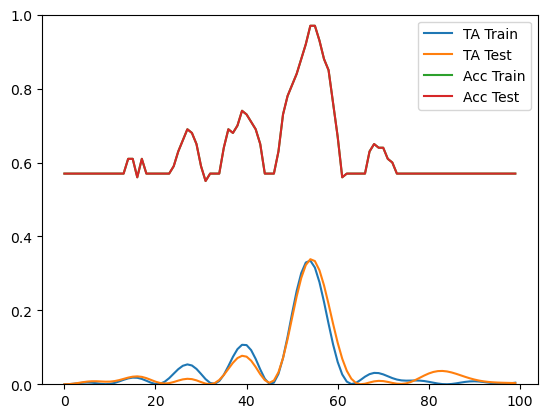

In [35]:
plt.ylim(0,1)
plt.plot(TA_trains, label = "TA Train")
plt.plot(TA_tests, label = "TA Test")
plt.plot(accuracy_trains, label = "Acc Train")
plt.plot(accuracy_trains, label = "Acc Test")
plt.legend()

In [41]:
np.corrcoef(TA_trains,accuracy_trains)

array([[1.        , 0.96887713],
       [0.96887713, 1.        ]])

In [42]:
np.corrcoef(TA_tests,accuracy_tests)

array([[1.        , 0.75670069],
       [0.75670069, 1.        ]])

In [43]:
np.corrcoef(TA_trains,accuracy_tests)

array([[1.        , 0.69558539],
       [0.69558539, 1.        ]])

In [84]:
dev = qml.device('default.qubit', wires=2)

In [85]:
@qml.qnode(dev)
def circ(xi, params):
    qml.Hadamard(wires=0)
    qml.RZ(params[0]*xi[0], wires=0)
    # qml.Hadamard(wires=0)
    
    qml.Hadamard(wires=1)
    qml.RZ(params[0]*xi[1], wires=1)
    # qml.Hadamard(wires=1)

    qml.MultiRZ(params[1]*(1-xi[1])*(1-xi[0]), wires=[0,1])

    qml.Hadamard(wires=0)
    qml.RZ(params[0]*xi[0], wires=0)
    # qml.Hadamard(wires=0)
    
    qml.Hadamard(wires=1)
    qml.RZ(params[0]*xi[1], wires=1)
    # qml.Hadamard(wires=1)

    qml.MultiRZ(params[1]*(1-xi[1])*(1-xi[0]), wires=[0,1])
    
    return qml.state()

In [86]:
N = 100

x_train = np.random.rand(N,2)*2-1
y_train = (-1)**np.floor([10*np.sqrt(np.dot(_, __)) for _, __ in zip(x_train, x_train)])

x_test = np.random.rand(N,2)*2-1
y_test = (-1)**np.floor([10*np.sqrt(np.dot(_, __)) for _, __ in zip(x_test, x_test)])

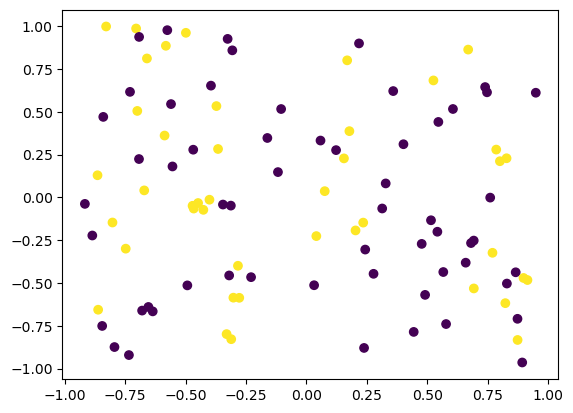

In [87]:
plt.scatter(np.transpose(x_train)[0],np.transpose(x_train)[1], c=y_train)

In [114]:
def index(i, N_points):
    x = i%N_points
    y = i//(N_points)%N_points
    z = i//(N_points**2)%N_points
    return x,y,z

In [126]:
N_points = 20
w1 = np.linspace(0,2*np.pi*(10-1),N_points)
w2 = np.linspace(0,2*np.pi*(10-1),N_points)
w3 = np.linspace(0,2*np.pi*(10-1),N_points)

TA_trains=np.zeros((N_points,N_points,N_points))
TA_tests=np.zeros((N_points,N_points,N_points))
accuracy_tests=np.zeros((N_points,N_points,N_points))
accuracy_trains=np.zeros((N_points,N_points,N_points))

with Pool() as pool:
        result = pool.map(foo, product(w1,w2,w2))
        for i, res in enumerate(result):
            TA_train, TA_test, accuracy_test, accuracy_train = res
            x, y, z = index(i, N_points)
            TA_trains[x,y,z]=TA_train
            TA_tests[x,y,z]=TA_test
            accuracy_tests[x,y,z]=accuracy_test
            accuracy_trains[x,y,z]=accuracy_train

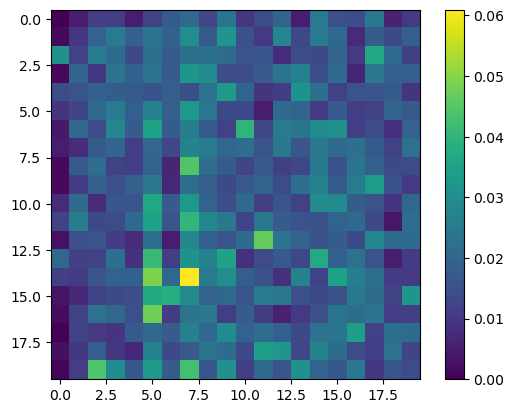

In [136]:
plt.imshow(TA_tests[0,:,:])
plt.colorbar();

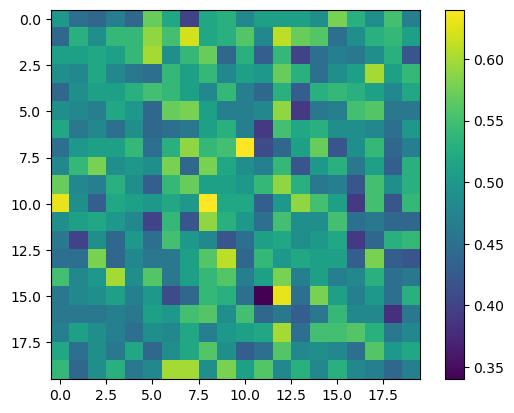

In [137]:
plt.imshow(accuracy_tests[0,:,:])
plt.colorbar();

In [141]:
np.corrcoef(TA_trains[0,:,:].reshape(400),accuracy_trains[0,:,:].reshape(400))

array([[1.       , 0.7488378],
       [0.7488378, 1.       ]])

In [142]:
np.corrcoef(TA_tests[0,:,:].reshape(400),accuracy_tests[0,:,:].reshape(400))

array([[1.        , 0.12134056],
       [0.12134056, 1.        ]])

In [143]:
np.corrcoef(TA_trains[0,:,:].reshape(400),accuracy_tests[0,:,:].reshape(400))

array([[ 1.        , -0.01096977],
       [-0.01096977,  1.        ]])

c:\Users\390194\Anaconda3\envs\QSVM\lib\site-packages\pennylane\numpy\tensor.py:155: RuntimeWarning: invalid value encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


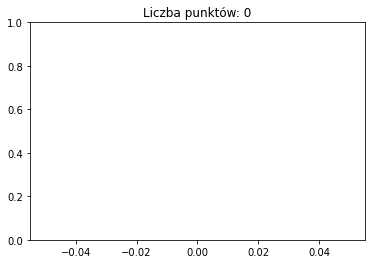

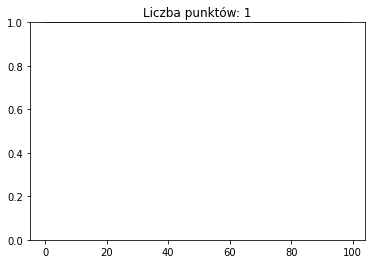

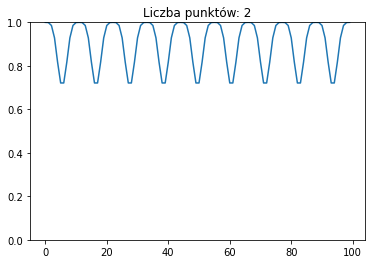

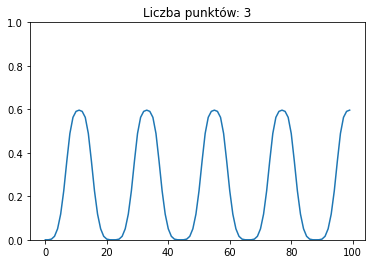

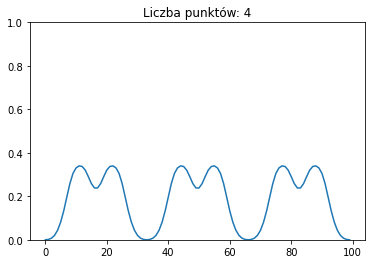

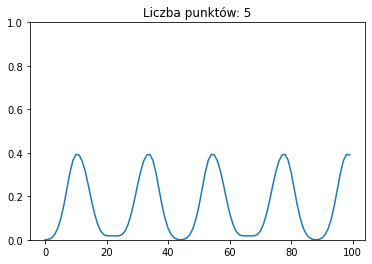

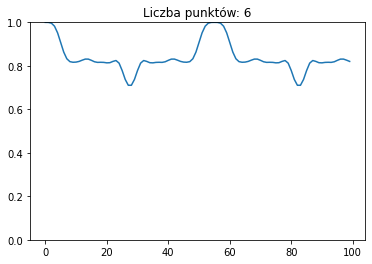

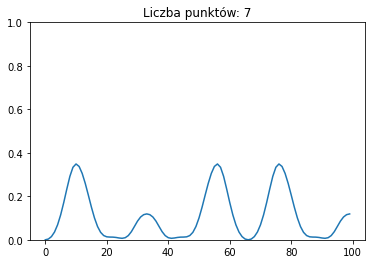

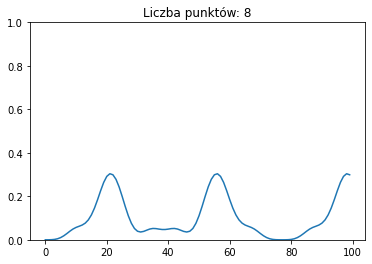

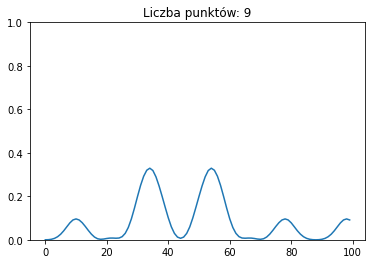

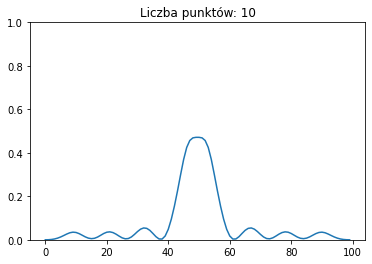

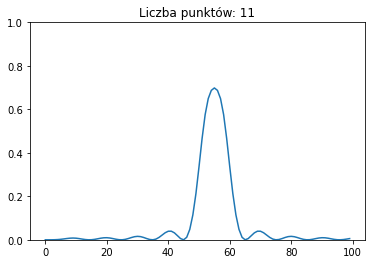

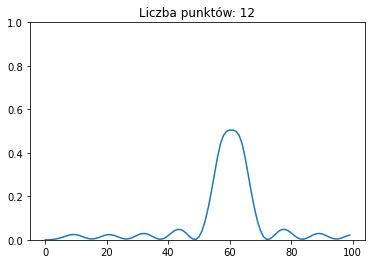

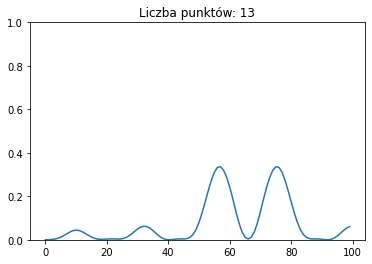

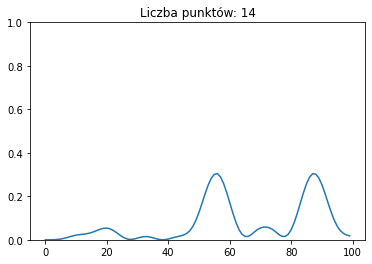

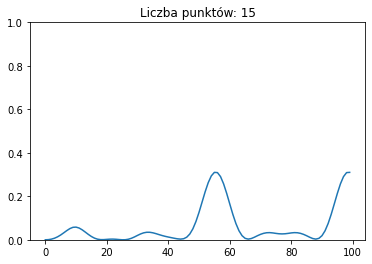

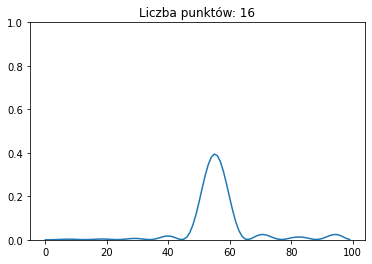

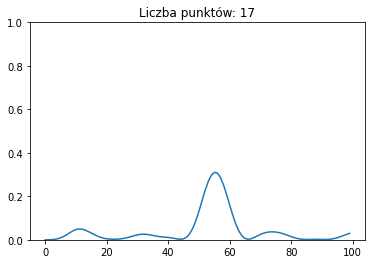

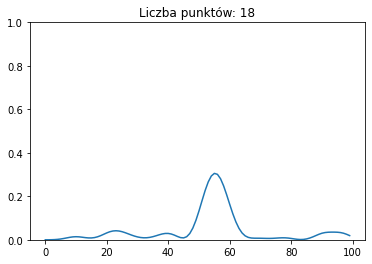

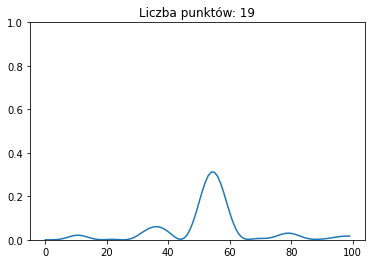

In [46]:
N_points = 100
w1 = np.linspace(0,2*np.pi*(10-1),N_points)

for N in range(20):
    x = np.linspace(0,1,N)
    y = (-1)**np.floor(10*x)

    TAs = []
    for i, p1 in enumerate(w1):
        ker_matrix = kernel_matrix(x, [p1], circ)
        TAs.append(target_alignment_matrix(ker_matrix, y))
    plt.ylim(0,1)
    plt.title('Liczba punktów: '+str(N))
    plt.plot(TAs)
    plt.show()

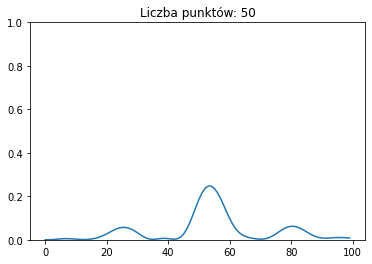

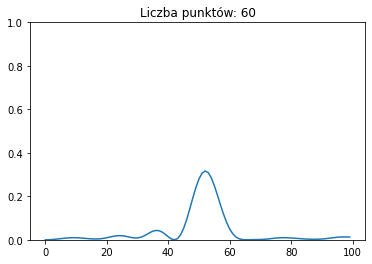

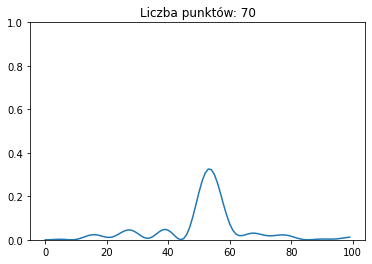

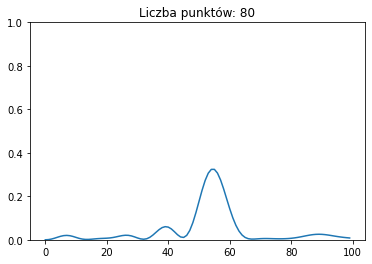

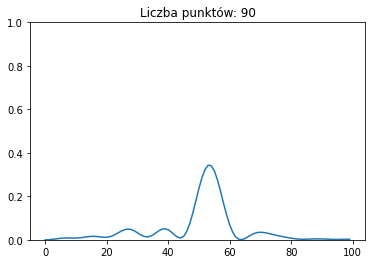

In [70]:
N_points = 100
w1 = np.linspace(0,2*np.pi*(10-1),N_points)

for N in range(50,100,10):
    x = np.random.rand(N)
    y = (-1)**np.floor(10*x)
    x+=np.random.normal(0,0.2*0.1)
    TAs = []
    for i, p1 in enumerate(w1):
        ker_matrix = kernel_matrix(x, [p1], circ)
        TAs.append(target_alignment_matrix(ker_matrix, y))
    plt.ylim(0,1)
    plt.title('Liczba punktów: '+str(N))
    plt.plot(TAs)
    plt.show()

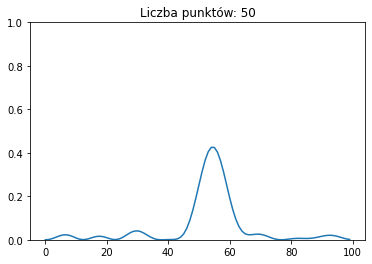

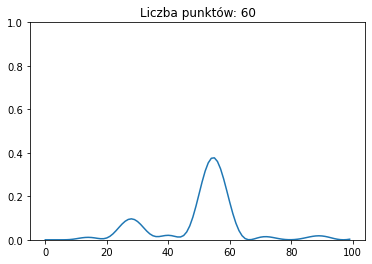

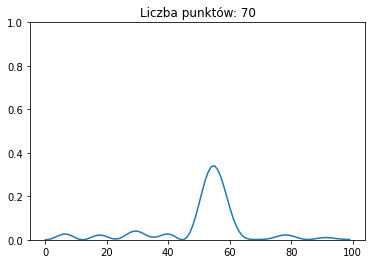

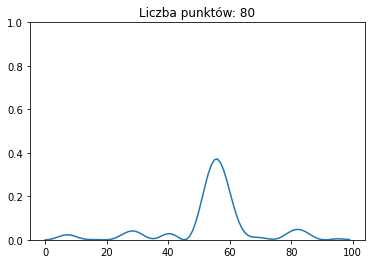

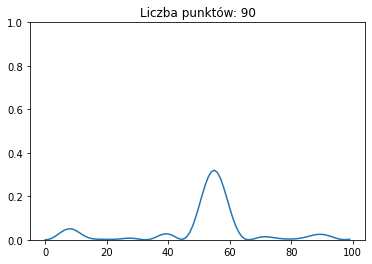

In [56]:
N_points = 100
w1 = np.linspace(0,2*np.pi*(10-1),N_points)

for N in range(50,100,10):
    x = np.random.rand(N)
    y = (-1)**np.floor(10*x)
    TAs = []
    for i, p1 in enumerate(w1):
        ker_matrix = kernel_matrix(x, [p1], circ)
        TAs.append(target_alignment_matrix(ker_matrix, y))
    plt.ylim(0,1)
    plt.title('Liczba punktów: '+str(N))
    plt.plot(TAs)
    plt.show()

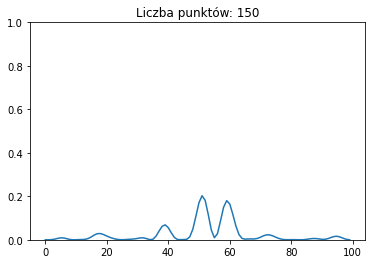

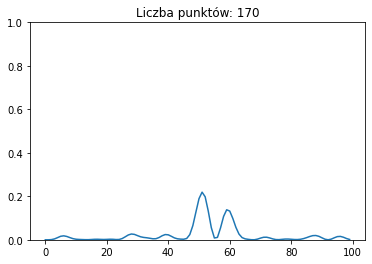

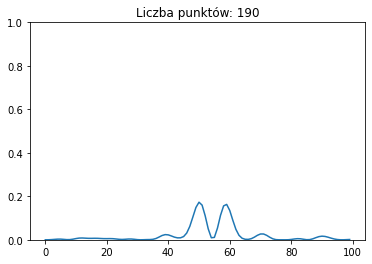

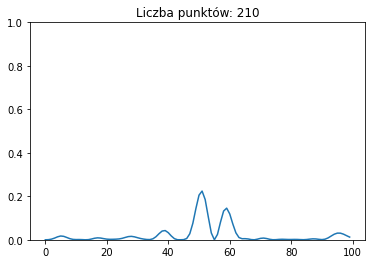

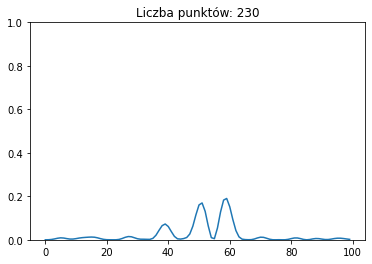

In [68]:
N_points = 100
w1 = np.linspace(0,2*np.pi*(10-1),N_points)

for N in range(150,250,20):
    x = np.random.rand(N)*2-1
    y = (-1)**np.floor(10*np.abs(x))

    TAs = []
    for i, p1 in enumerate(w1):
        ker_matrix = kernel_matrix(x, [p1], circ)
        TAs.append(target_alignment_matrix(ker_matrix, y))
    plt.ylim(0,1)
    plt.title('Liczba punktów: '+str(N))
    plt.plot(TAs)
    plt.show()

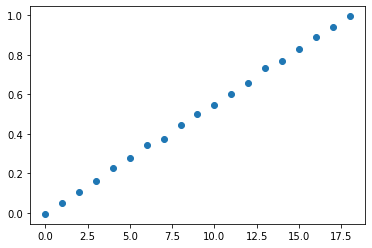

In [105]:
noise = 0.1
x = np.linspace(0,1,N)+np.random.normal(0,noise*1/(N-1),size=N)
plt.plot(x,'o')

In [106]:
noise = 0.1
for N in range(2,20):
    x = np.linspace(0,1,N)+np.random.normal(0,noise*1/(N-1),size=N)
    y = (-1)**np.linspace(0,N-1,N)

    N_points = 100
    w = np.linspace(0,2*np.pi*(N-1),N_points)

    TAs = []
    for p in w:
        ker_matrix = kernel_matrix(x, [p], circ)
        TAs.append(target_alignment_matrix(ker_matrix, y))

    plt.plot(w,TAs)
    plt.savefig('landscape'+str(N)+'.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [138]:
from itertools import product

In [155]:
N=5
x1 = np.linspace(0,1,N)
x2 = np.linspace(0,1,N)
y = (-1)**np.linspace(0,N-1,N)
y = np.outer(y,y).flatten()
x = list(product(x1,x2))

In [156]:
dev = qml.device('default.qubit', wires=2)

In [200]:
@qml.qnode(dev)
def circ(xi, params):
    qml.Hadamard(wires=0)
    qml.RZ(params[0]*xi[0], wires=0)
    # qml.Hadamard(wires=0)
    
    qml.Hadamard(wires=1)
    qml.RZ(params[0]*xi[1], wires=1)
    # qml.Hadamard(wires=1)

    qml.MultiRZ(params[1]*(1-xi[1])*(1-xi[0]), wires=[0,1])

    qml.Hadamard(wires=0)
    qml.RZ(params[0]*xi[0], wires=0)
    # qml.Hadamard(wires=0)
    
    qml.Hadamard(wires=1)
    qml.RZ(params[0]*xi[1], wires=1)
    # qml.Hadamard(wires=1)

    qml.MultiRZ(params[1]*(1-xi[1])*(1-xi[0]), wires=[0,1])
    
    return qml.state()

In [201]:
params = 2*np.pi*np.random.rand(2)
print(params)

[3.41164936 6.12593133]


In [206]:
N_points = 55
w1 = np.linspace(0,2*np.pi*(N-1),N_points)
w2 = np.linspace(0,2*np.pi*(N-1),N_points)

TAs = np.zeros((N_points,N_points))
for i, p1 in enumerate(w1):
    for j, p2 in enumerate(w2):
        ker_matrix = kernel_matrix(x, [p1,p2], circ)
        TAs[i,j]=target_alignment_matrix(ker_matrix, y)

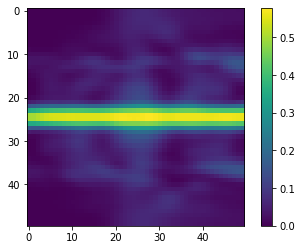

In [205]:
plt.imshow(TAs)
plt.colorbar();

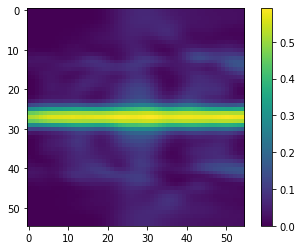

In [207]:
plt.imshow(TAs)
plt.colorbar();

In [198]:
N_points = 50
w2 = np.linspace(0,2*np.pi*(N-1),N_points)

TAs = []
for i, p1 in enumerate(w1):
    ker_matrix = kernel_matrix(x, [p1,0], circ)
    TAs.append(target_alignment_matrix(ker_matrix, y))

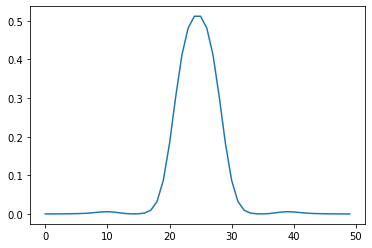

In [199]:
plt.plot(TAs)

In [232]:
N_points_x = 100
N_points_y = 100
p0 = np.linspace(0,2*np.pi,N_points_y)
p1 = np.linspace(0,2*np.pi,N_points_y)
p2 = np.linspace(0,2*np.pi*(N-1),N_points_x)

In [233]:
# N_points = 150
# # p = 4*np.pi*np.linspace(0,1,N_points)
# p = np.linspace(0,2*np.pi*(N-1),N_points)

In [234]:
# TAs_diff_p1 = []
# for pk in p1:
#     TAs = np.zeros((N_points_x, N_points_y))
#     for i, pi in enumerate(p0):
#         for j, pj in enumerate(p2):
#             ker_matrix = kernel_matrix(x, [pi,pk,pj], circ)
#             TAs[j,i]=target_alignment_matrix(ker_matrix, y)
#     TAs_diff_p1.append(TAs)

In [235]:
TAs = np.zeros((N_points_x, N_points_y))
for i, pi in enumerate(p0):
    for j, pj in enumerate(p1):
        ker_matrix = kernel_matrix(x, [pi,pj,np.pi*(N-1)], circ)
        TAs[j,i]=target_alignment_matrix(ker_matrix, y)

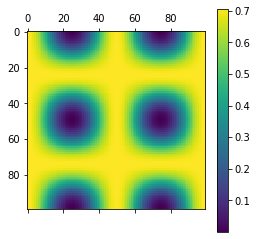

In [236]:
plt.matshow(TAs)
plt.colorbar()

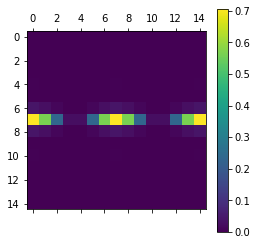

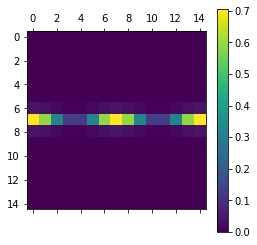

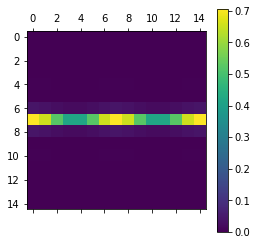

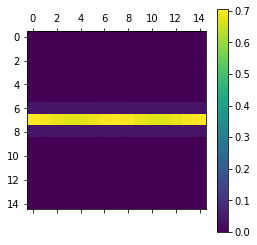

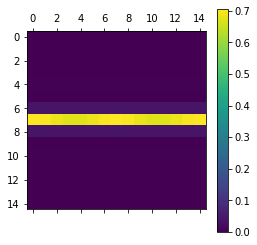

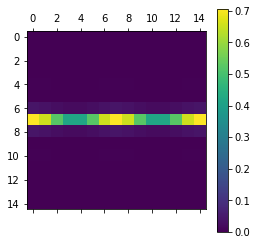

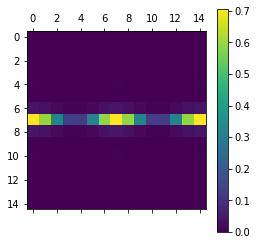

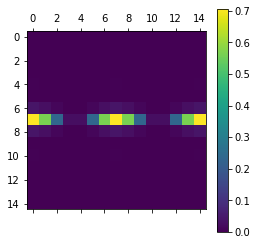

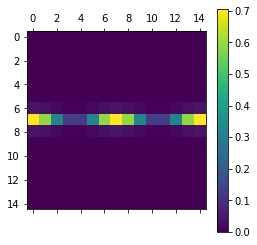

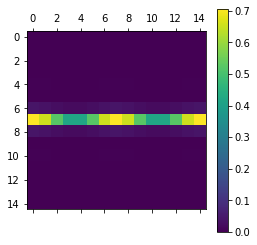

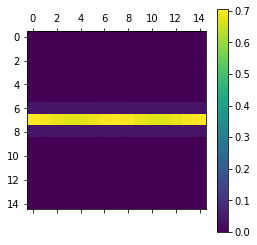

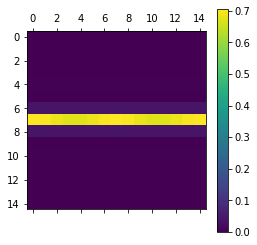

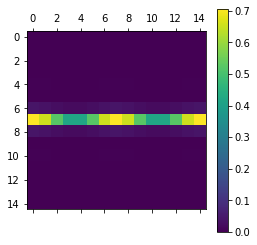

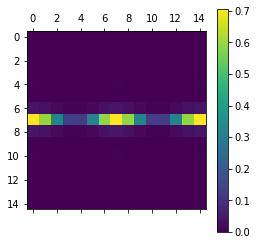

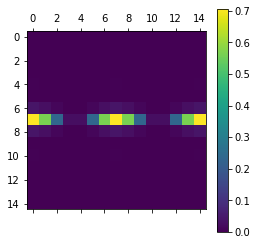

In [229]:
# for i in range(N_points_y):
#     plt.matshow(TAs_diff_p1[i])
#     plt.colorbar()

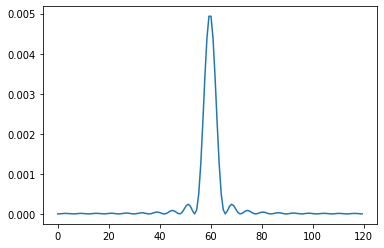

In [194]:
# plt.plot(p2, TAs)